In [1]:
import tensorflow as tf
tf.__version__

'2.8.0'

## 1. 데이터 준비

In [2]:
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './images'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=14,
                                                  class_mode='categorical',
                                                  target_size=(150, 150))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                      batch_size=14,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

Found 784 images belonging to 7 classes.
Found 194 images belonging to 7 classes.


In [4]:
LABELS = {
    0: 'anger',
    1: 'comtempt',
    2: 'disgust',
    3: 'fear',
    4: 'happy', 
    5: 'sadness',
    6: 'surprise'
}

## 2. 모델 학습

In [5]:
vgg_model = tf.keras.applications.VGG16(weights = 'imagenet',
                                        include_top = False,
                                        input_shape=(160, 160, 3))
vgg_model.summary()

2022-11-28 09:36:42.019147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 09:36:42.973746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 09:36:42.974963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 09:36:43.000911: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [6]:
import keras

model = tf.keras.Sequential()

for layer in vgg_model.layers[:-1]: 
    model.add(layer)

model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(7, activation='softmax'))    

for layer in model.layers[:-6]:
        layer.trainable = False
        
model.summary()

# adam=optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 40, 40, 256)       2

In [7]:
# 확인
for layer in model.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7fd714e51160> False
<keras.layers.convolutional.Conv2D object at 0x7fd714e51880> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd714e517f0> False
<keras.layers.convolutional.Conv2D object at 0x7fd714dab1c0> False
<keras.layers.convolutional.Conv2D object at 0x7fd714db0e50> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd714db0b50> False
<keras.layers.convolutional.Conv2D object at 0x7fd7148f7280> False
<keras.layers.convolutional.Conv2D object at 0x7fd7148f9ca0> False
<keras.layers.convolutional.Conv2D object at 0x7fd7148f7430> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd7148f99a0> False
<keras.layers.convolutional.Conv2D object at 0x7fd714908460> False
<keras.layers.convolutional.Conv2D object at 0x7fd714908790> False
<keras.layers.convolutional.Conv2D object at 0x7fd714e51a30> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd714908850> False
<keras.layers.convolutional.Conv2D object at 0x7fd714911e80> T

In [8]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=200,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[es_callback]
)

Epoch 1/200


2022-11-28 09:37:18.544571: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-11-28 09:37:29.977167: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


56/56 [==============================] - 55s 216ms/step - loss: 2.1254 - accuracy: 0.2219 - val_loss: 1.8326 - val_accuracy: 0.2113
Epoch 2/200
56/56 [==============================] - 7s 117ms/step - loss: 1.8502 - accuracy: 0.2602 - val_loss: 1.9154 - val_accuracy: 0.2113
Epoch 3/200
56/56 [==============================] - 6s 108ms/step - loss: 1.8614 - accuracy: 0.2640 - val_loss: 1.7784 - val_accuracy: 0.2732
Epoch 4/200
56/56 [==============================] - 6s 113ms/step - loss: 1.7089 - accuracy: 0.3291 - val_loss: 1.6099 - val_accuracy: 0.4072
Epoch 5/200
56/56 [==============================] - 6s 114ms/step - loss: 1.6990 - accuracy: 0.3839 - val_loss: 1.5281 - val_accuracy: 0.4381
Epoch 6/200
56/56 [==============================] - 8s 139ms/step - loss: 1.5681 - accuracy: 0.3980 - val_loss: 1.4368 - val_accuracy: 0.4381
Epoch 7/200
56/56 [==============================] - 8s 142ms/step - loss: 1.6059 - accuracy: 0.4184 - val_loss: 1.3966 - val_accuracy: 0.4381
Epoch 8/20

Epoch 58/200
56/56 [==============================] - 6s 103ms/step - loss: 0.1284 - accuracy: 0.9554 - val_loss: 0.2485 - val_accuracy: 0.9175
Epoch 59/200
56/56 [==============================] - 6s 103ms/step - loss: 0.0694 - accuracy: 0.9758 - val_loss: 0.0693 - val_accuracy: 0.9691
Epoch 60/200
56/56 [==============================] - 6s 103ms/step - loss: 0.0942 - accuracy: 0.9643 - val_loss: 0.3105 - val_accuracy: 0.9227
Epoch 61/200
56/56 [==============================] - 6s 100ms/step - loss: 0.1072 - accuracy: 0.9668 - val_loss: 0.1218 - val_accuracy: 0.9536
Epoch 62/200
56/56 [==============================] - 6s 102ms/step - loss: 0.1522 - accuracy: 0.9490 - val_loss: 0.1704 - val_accuracy: 0.9485
Epoch 63/200
56/56 [==============================] - 6s 102ms/step - loss: 0.1122 - accuracy: 0.9579 - val_loss: 0.4351 - val_accuracy: 0.8814
Epoch 64/200
56/56 [==============================] - 6s 104ms/step - loss: 0.0797 - accuracy: 0.9719 - val_loss: 0.0860 - val_accuracy:

## 3. 모델 평가

In [9]:
import numpy as np

# 모델 평가하기
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)

-- Evaluate --


/tmp/ipykernel_397/1923243852.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, steps=5)


accuracy: 97.14%
-- Predict --


/tmp/ipykernel_397/1923243852.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  output = model.predict_generator(test_generator, steps=5)


{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}
[[0.005 0.935 0.000 0.037 0.011 0.004 0.008]
 [0.002 0.995 0.001 0.000 0.002 0.000 0.000]
 [0.000 0.000 0.000 0.994 0.000 0.001 0.006]
 [0.000 0.000 0.000 0.008 0.000 0.034 0.958]
 [0.002 0.004 0.000 0.022 0.000 0.952 0.019]
 [0.000 0.000 0.000 0.995 0.000 0.000 0.005]
 [0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000 0.000 0.000]
 [0.002 0.009 0.000 0.020 0.000 0.943 0.026]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000]
 [0.903 0.085 0.009 0.000 0.000 0.003 0.000]
 [0.470 0.000 0.000 0.000 0.000 0.530 0.000]
 [0.341 0.000 0.000 0.000 0.000 0.659 0.000]
 [0.000 0.000 0.000 1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000]
 [0.000 0.000 1.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.001 0.999 0.000 0.000]
 [0.000 0.000 1.000 0.000 0.000 0.000 0.000]
 [1.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 1.000 0.000]
 [0.00

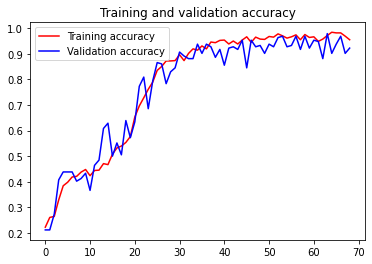

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

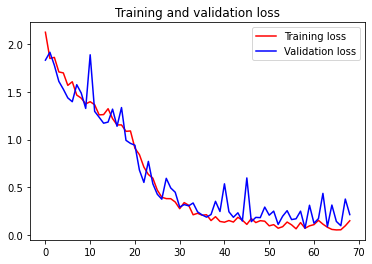

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [12]:
score = model.evaluate(test_generator, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.06934992223978043
Test accuracy: 0.969072163105011


In [ ]:
model.save('vgg16ToCam_백본1단까지조정.h5')

## 4. CAM

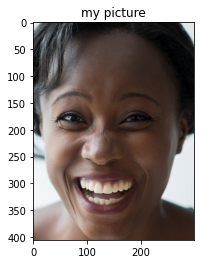

In [13]:
import cv2
from matplotlib import pyplot as plt


# from google.colab.patches import cv2_imshow

file_path='./testImages/happy/happyTest.jpg'
image=cv2.imread(file_path)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

In [14]:
cam_model = tf.keras.Model(model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

(1024, 7)

In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

def show_cam(image_value, features, results, label):
    '''
    Displays the class activation map of an image
 
    Args:
        image_value (tensor) -- preprocessed input image with size 160 x 160
        features (array) -- features of the image, shape (1, 20, 20, 512)
        results (array) -- output of the sigmoid layer
    '''
    features_for_img = features[0]
    # print("features_for_img:", features_for_img.shape)
    prediction = results[0]
    # print("prediction:", prediction.shape)
    class_activation_weigths = gap_weights[:,label]
    # print("class_activation_weigths:", class_activation_weigths.shape)
    class_activation_features = sp.ndimage.zoom(features_for_img, (16, 16, 1), order=2)
    # print("class_activation_features:", class_activation_features.shape)
    cam_output = np.dot(class_activation_features, class_activation_weigths)
    # print(cam_output.shape)
    cam_output = tf.reshape(cam_output, (160,160))
    # print("ss")
 
    # visualize the results
    print(f'softmax output: {results}')
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()


In [16]:
def normalize_and_resize(image):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, (160, 160))
    image = tf.expand_dims(image, axis=0)
    return image


model.predict(normalize_and_resize(image))

array([[0.000, 0.000, 0.000, 0.000, 1.000, 0.000, 0.000]], dtype=float32)

---------this is happy
softmax output: [[0.000 0.000 0.000 0.000 1.000 0.000 0.000]]


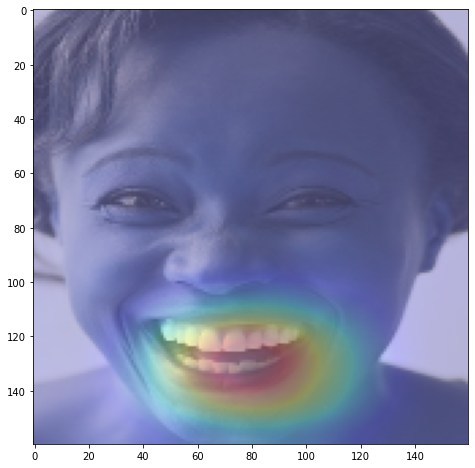

In [17]:
tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image))
image_value = normalize_and_resize(image)
print("---------this is", LABELS[lbl])
show_cam(image_value, features, results, lbl)

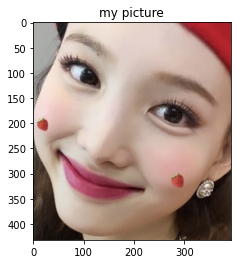

---------this is happy
softmax output: [[0.000 0.000 0.000 0.000 1.000 0.000 0.000]]


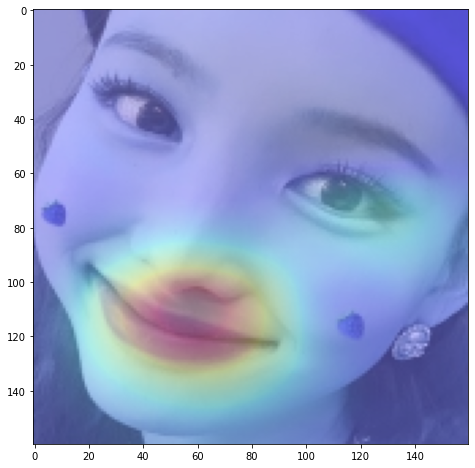

In [35]:
file_path2='./testImages2/test/good/KakaoTalk_20221108_135729635.jpg'
image2=cv2.imread(file_path2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image2), features, results, lbl)

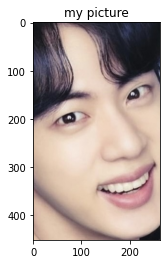

---------this is happy
softmax output: [[0.000 0.000 0.000 0.000 1.000 0.000 0.000]]


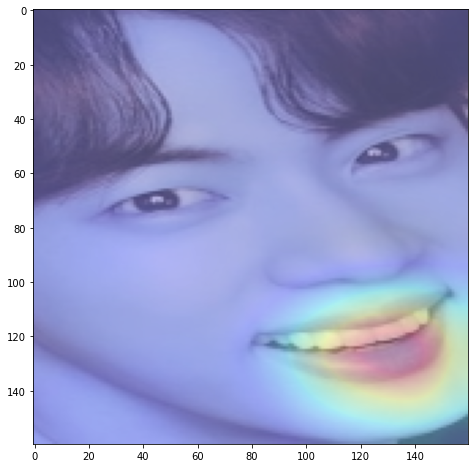

In [36]:
file_path2='./testImages2/test/good/KakaoTalk_20221108_135729635_08.jpg'
image2=cv2.imread(file_path2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image2), features, results, lbl)

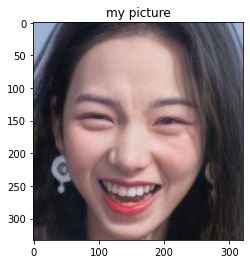

---------this is happy
softmax output: [[0.000 0.000 0.000 0.000 1.000 0.000 0.000]]


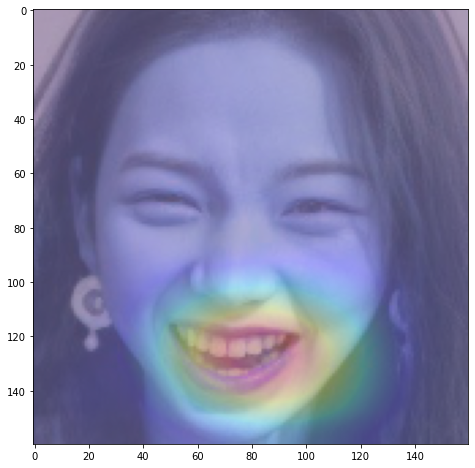

In [18]:
file_path2='./testImages/happy/happyTest2.jpg'
image2=cv2.imread(file_path2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()
tmp=model.predict(normalize_and_resize(image2))
lbl=tmp.argmax()
features,results = cam_model.predict(normalize_and_resize(image2))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image2), features, results, lbl)

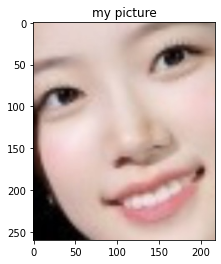

4
---------this is happy
softmax output: [[0.000 0.000 0.000 0.000 1.000 0.000 0.000]]


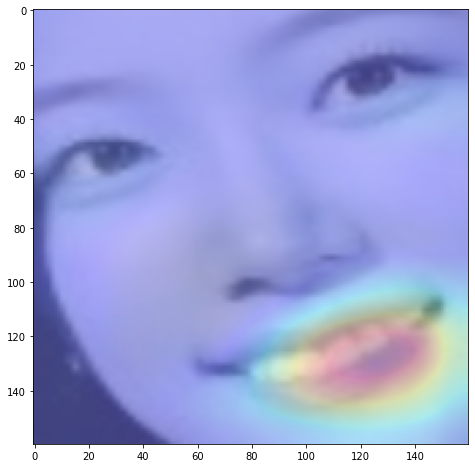

In [33]:
file_path='./testImages2/test/good/KakaoTalk_20221108_180641526_01.jpg'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

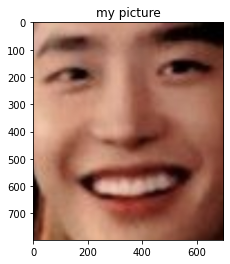

4
---------this is happy
softmax output: [[0.000 0.000 0.000 0.000 1.000 0.000 0.000]]


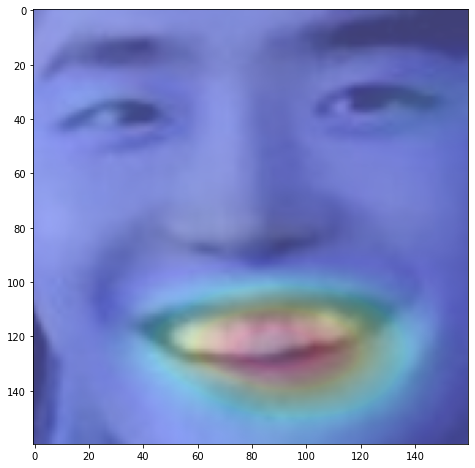

In [34]:
file_path='./testImages2/test/good/KakaoTalk_20221108_174852906_03.jpg'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

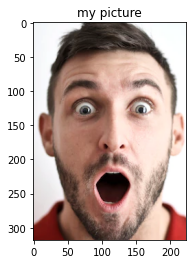

6
---------this is surprise
softmax output: [[0.000 0.000 0.000 0.000 0.000 0.000 1.000]]


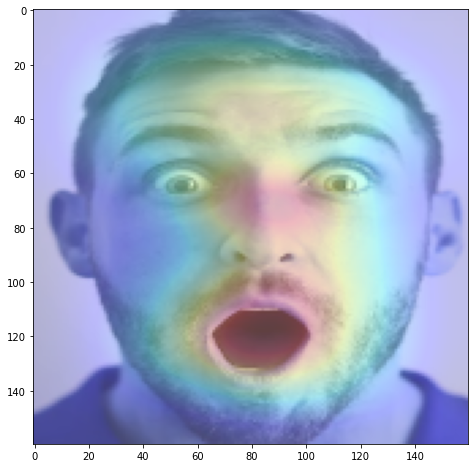

In [41]:
file_path='./testImages/surprise/surpriseTest.png'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

## 한계점 : 히트맵 분포가 이상할 때도 있음(아마 softmax값들이 서로 비슷비슷할 때 그런 듯함)

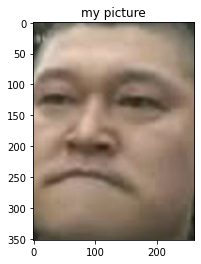

2
---------this is disgust
softmax output: [[0.442 0.045 0.487 0.001 0.003 0.021 0.000]]


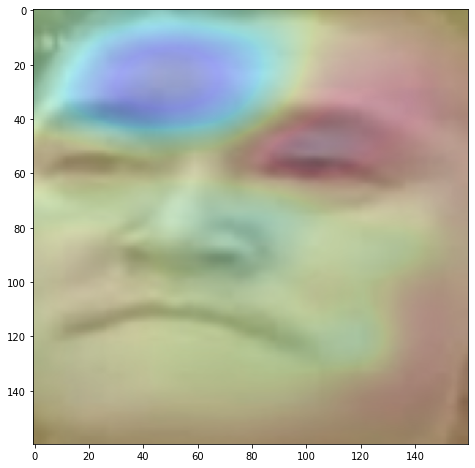

In [40]:
file_path='./testImages2/test/bad/KakaoTalk_20221108_135744367_06.jpg'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

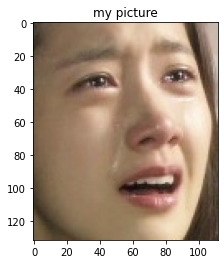

4
---------this is happy
softmax output: [[0.000 0.000 0.000 0.040 0.960 0.000 0.000]]


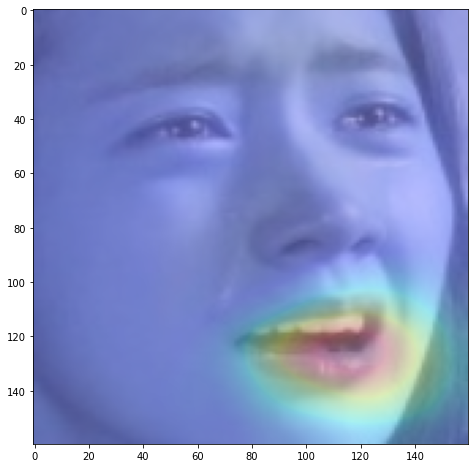

In [44]:
file_path='./testImages2/test/sad/1.jpg'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

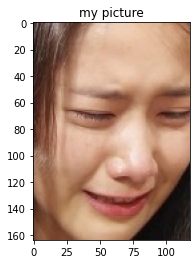

4
---------this is happy
softmax output: [[0.000 0.000 0.000 0.000 1.000 0.000 0.000]]


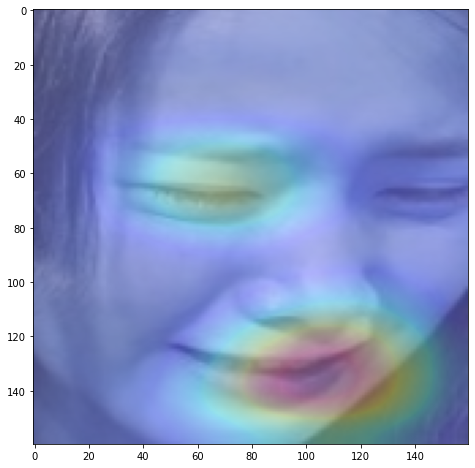

In [45]:
file_path='./testImages2/test/sad/2.jpg'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

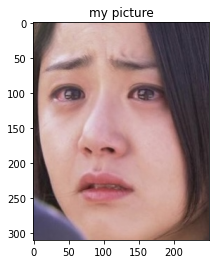

0
---------this is anger
softmax output: [[0.590 0.030 0.000 0.005 0.000 0.374 0.001]]


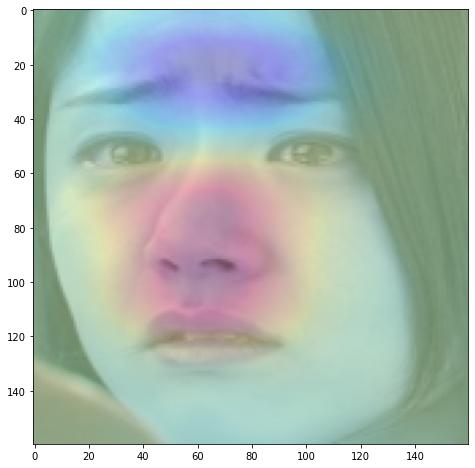

In [46]:
file_path='./testImages2/test/sad/3.jpg'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

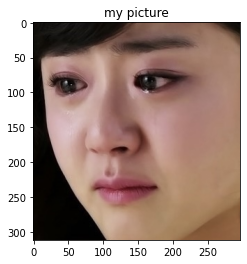

3
---------this is fear
softmax output: [[0.000 0.192 0.000 0.690 0.002 0.024 0.092]]


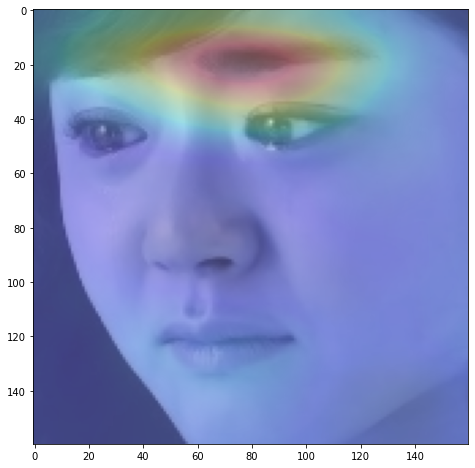

In [47]:
file_path='./testImages2/test/sad/4.jpg'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

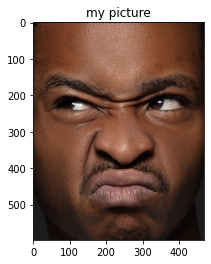

0
---------this is anger
softmax output: [[0.986 0.000 0.001 0.000 0.000 0.013 0.000]]


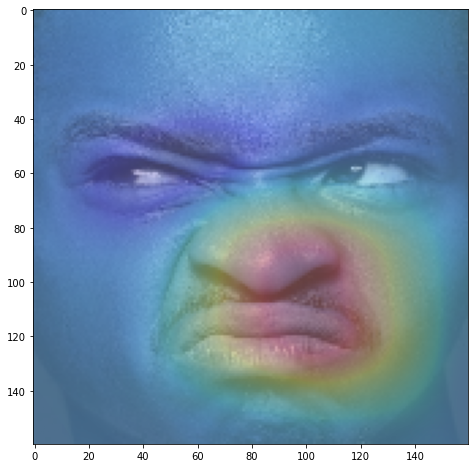

In [22]:
file_path='./testImages/disgust/disgustTest.png'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

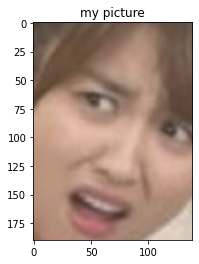

4
---------this is happy
softmax output: [[0.000 0.020 0.014 0.001 0.965 0.000 0.000]]


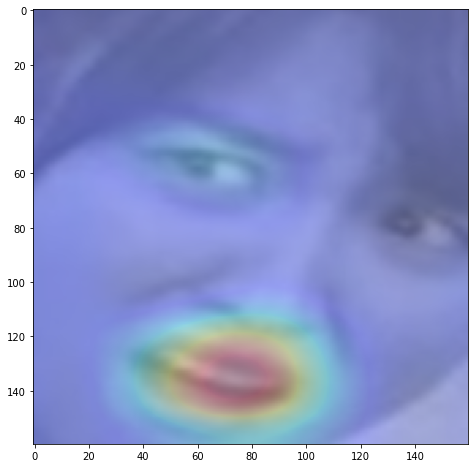

In [29]:
file_path='./testImages2/test/bad/KakaoTalk_20221108_135744367_09.jpg'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)

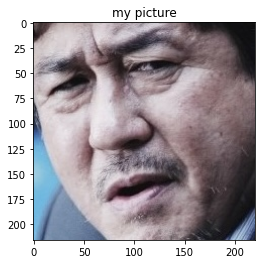

2
---------this is disgust
softmax output: [[0.000 0.000 1.000 0.000 0.000 0.000 0.000]]


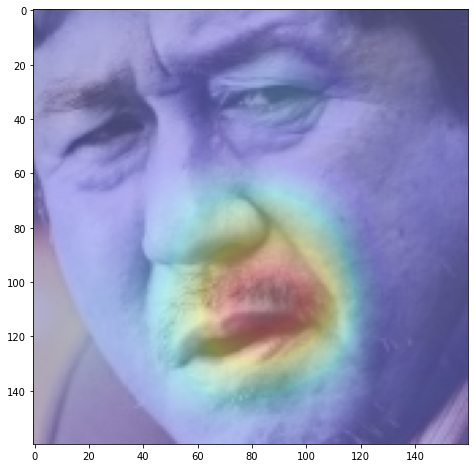

In [48]:
file_path='./testImages2/test/bad/KakaoTalk_20221108_135744367_11.jpg'
image=cv2.imread(file_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('my picture')
plt.show()

tmp=model.predict(normalize_and_resize(image))
lbl=tmp.argmax()
print(lbl)
features,results = cam_model.predict(normalize_and_resize(image))
print("---------this is", LABELS[lbl])
show_cam(normalize_and_resize(image), features, results, lbl)